*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/nlp-with-pytorch/blob/master/chapter_4/4_2_mlp_surnames/4_2_Classifying_Surnames_with_an_MLP.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/nlp-with-pytorch/blob/master/chapter_4/4_2_mlp_surnames/4_2_Classifying_Surnames_with_an_MLP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

# 다층 퍼셉트론으로 성씨 분류하기

## 임포트

In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

## 데이터 벡터 변환 클래스

### `Vocabulary`

In [2]:
class Vocabulary(object):
    """ 매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
            add_unk (bool): UNK 토큰을 추가할지 지정하는 플래그
            unk_token (str): Vocabulary에 추가할 UNK 토큰
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """ 토큰 리스트를 Vocabulary에 추가합니다.

        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.

        매개변수:
            token (str): 찾을 토큰
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.

        매개변수:
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("Vocabulary에 인덱스(%d)가 없습니다." % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### `Vectorizer`

In [3]:
class SurnameVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, surname_vocab, nationality_vocab):
        """
        매개변수:
            surname_vocab (Vocabulary): 문자를 정수에 매핑하는 Vocabulary 객체
            nationality_vocab (Vocabulary): 국적을 정수에 매핑하는 Vocabulary 객체
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """ 성씨에 대한 원-핫 벡터를 만듭니다

        매개변수:
            surname (str): 성씨
        반환값:
            one_hot (np.ndarray): 원-핫 벡터
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """ 데이터셋 데이터프레임에서 Vectorizer 객체를 만듭니다

        매개변수:
            surname_df (pandas.DataFrame): 성씨 데이터셋
        반환값:
            SurnameVectorizer 객체
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

### `Dataset`

In [4]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        매개변수:
            surname_df (pandas.DataFrame): 데이터셋
            vectorizer (SurnameVectorizer): SurnameVectorizer 객체
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # 클래스 가중치
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """ 데이터셋을 로드하고 새로운 SurnameVectorizer 객체를 만듭니다

        매개변수:
            review_csv (str): 데이터셋의 위치
        반환값:
            SurnameDataset의 인스턴스
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """데이터셋을 로드하고 새로운 SurnameVectorizer 객체를 만듭니다.
        캐시된 SurnameVectorizer 객체를 재사용할 때 사용합니다.

        매개변수:
            surname_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): SurnameVectorizer 객체의 저장 위치
        반환값:
            SurnameDataset의 인스턴스
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 SurnameVectorizer 객체를 로드하는 정적 메서드

        매개변수:
            vectorizer_filepath (str): 직렬화된 SurnameVectorizer 객체의 위치
        반환값:
            SurnameVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """ SurnameVectorizer 객체를 json 형태로 디스크에 저장합니다

        매개변수:
            vectorizer_filepath (str): SurnameVectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer

    def set_split(self, split="train"):
        """ 데이터프레임에 있는 열을 사용해 분할 세트를 선택합니다

        매개변수:
            split (str): "train", "val", "test" 중 하나
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """ 파이토치 데이터셋의 주요 진입 메서드

        매개변수:
            index (int): 데이터 포인트의 인덱스
        반환값:
            데이터 포인트의 특성(x_surname)과 레이블(y_nationality)로 이루어진 딕셔너리
        """
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """ 배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다

        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size


def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## 모델: `SurnameClassifier`

In [5]:
class SurnameClassifier(nn.Module):
    """ 성씨 분류를 위한 다층 퍼셉트론 """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        매개변수:
            input_dim (int): 입력 벡터 크기
            hidden_dim (int): 첫 번째 Linear 층의 출력 크기
            output_dim (int): 두 번째 Linear 층의 출력 크기
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """MLP의 정방향 계산

        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)입니다.
            apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스-엔트로피 손실을 사용하려면 False로 지정해야 합니다.
        반환값:
            결과 텐서. tensor.shape은 (batch, output_dim)입니다.
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## 모델 훈련

### 헬퍼 함수

In [6]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']: #모델이 좋아질때만 저장하고싶다.loss가 어떤값보다 적으면 저장하겠다
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria #early_stopping_criteri = 5, 5번보다 여러번 연속으로 loss가 개선되지 않으면, 종료하겠다.

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### 유틸리티

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### 설정

In [8]:
args = Namespace(
    # 날짜와 경로 정보
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # 모델 하이퍼파라미터
    hidden_dim=300,
    # 훈련 하이퍼파라미터
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # 실행 옵션
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	model_storage/ch4/surname_mlp/vectorizer.json
	model_storage/ch4/surname_mlp/model.pth
CUDA 사용여부: False


### 초기화

In [9]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 라이트 버전의 데이터를 다운로드하세요.
!mkdir data                                               #Data 다운받는것
!wget https://git.io/JtaFp -O data/download.py
!wget https://git.io/Jtabe -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

--2024-04-20 03:01:09--  https://git.io/JtaFp
Resolving git.io (git.io)... 140.82.113.22
Connecting to git.io (git.io)|140.82.113.22|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_4/4_2_mlp_surnames/data/download.py [following]
--2024-04-20 03:01:09--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_4/4_2_mlp_surnames/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2024-04-20 03:01:10 (17.8 MB/s) - ‘data/download.py’ saved [1572/1572]

--2024-04-20 03:01:10--  htt

In [10]:
if args.reload_from_files:
    # 체크포인트에서 훈련을 다시 시작
    print("로딩!")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer 만들기
    print("새로 만들기!") #dataset
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab),
                               hidden_dim=args.hidden_dim,
                               output_dim=len(vectorizer.nationality_vocab))

새로 만들기!


In [11]:
df = pd.read_csv("data/surnames/surnames_with_splits.csv", header=0)
df

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh
...,...,...,...,...
10975,Vietnamese,11,test,Dinh
10976,Vietnamese,11,test,Phung
10977,Vietnamese,11,test,Quang
10978,Vietnamese,11,test,Vu


In [12]:
df.nationality.unique()

array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
       'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
       'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
       'Vietnamese'], dtype=object)

In [13]:
len(df.nationality.unique())

18

In [14]:
len(df.surname.unique())

9041

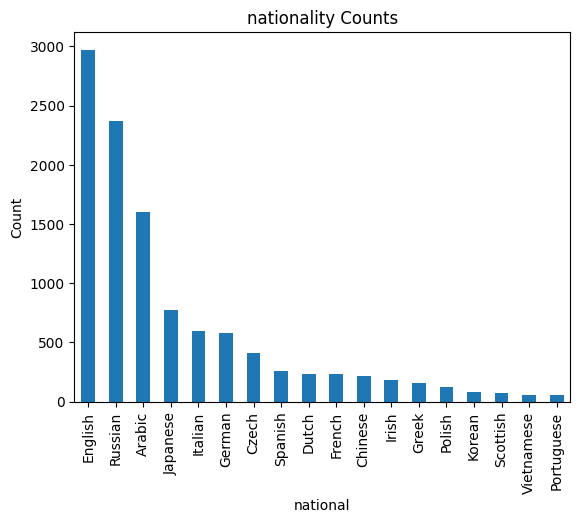

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

nat_count = df['nationality'].value_counts()

# 결과를 바 차트로 표현
nat_count.plot(kind='bar')
plt.xlabel('national')
plt.ylabel('Count')
plt.title('nationality Counts')
plt.show()

### 훈련 반복

In [16]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)


loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)#adam은 optimizer,  lr=args.learning_rate->처음 lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, #lr=learning rate는 학습중에 바꿔주는것
                                                 mode='min', factor=0.5, # lr_scheduler는 학습중에 lr바꿔준다.
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(batch_dict['x_surname'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step() #weight업데이트
            # -----------------------------------------

            # 정확도를 계산합니다 #중간중간 정확도 계산후 weight업데이트반복
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 바 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier(batch_dict['x_surname'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss) #중간중간 loss와 accuracy를 넣는다. 이걸보고 중간에 저장할지,학습을끝낼지 결정
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,  #update_train_state는 학습을 끝낼지 결정
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_surname'])

    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [18]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 1.7831666803359985;
테스트 정확도: 46.31249999999999


### 추론

In [19]:
def predict_nationality(surname, classifier, vectorizer):
    """새로운 성씨로 국적 예측하기

    매개변수:
        surname (str): 분류할 성씨
        classifier (SurnameClassifer): 분류기 객체
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
    반환값:
        가장 가능성이 높은 국적과 확률로 구성된 딕셔너리
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).view(1, -1)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [20]:
new_surname = input("분류하려는 성씨를 입력하세요: ")
classifier = classifier.to("cpu")
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

분류하려는 성씨를 입력하세요: Lee
Lee -> Chinese (p=0.43)


### 최상위 K 개 예측

In [21]:
vectorizer.nationality_vocab.lookup_index(8)

'Irish'

In [22]:
def predict_topk_nationality(name, classifier, vectorizer, k=5):
    """새로운 성씨에 대한 최상위 K개 국적을 예측합니다

    매개변수:
        surname (str): 분류하려는 성씨
        classifier (SurnameClassifer): 분류기 객체
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
        k (int): the number of top nationalities to return
    반환값:
        딕셔너리 리스트, 각 딕셔너리는 국적과 확률로 구성됩니다.
    """
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)

    # 반환되는 크기는 (1,k)입니다
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]

    results = []
    for prob_value, index in zip(probability_values, indices):
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        results.append({'nationality': nationality,
                        'probability': prob_value})

    return results


new_surname = input("분류하려는 성씨를 입력하세요: ")
classifier = classifier.to("cpu")

k = int(input("얼마나 많은 예측을 보고 싶나요? "))
if k > len(vectorizer.nationality_vocab):
    print("앗! 전체 국적 개수보다 큰 값을 입력했습니다. 모든 국적에 대한 예측을 반환합니다. :)")
    k = len(vectorizer.nationality_vocab)

predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("최상위 {}개 예측:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))

분류하려는 성씨를 입력하세요: Kim
얼마나 많은 예측을 보고 싶나요? 5
최상위 5개 예측:
Kim -> Korean (p=0.37)
Kim -> Japanese (p=0.17)
Kim -> Arabic (p=0.11)
Kim -> German (p=0.08)
Kim -> Czech (p=0.07)


In [23]:
print(len(dataset.train_df))
print(len(dataset.val_df))
print(len(dataset.test_df))

7680
1640
1660


In [24]:
new_surname = input("분류하려는 성씨를 입력하세요: ")
classifier = classifier.to("cpu")

k = int(input("얼마나 많은 예측을 보고 싶나요? "))
if k > len(vectorizer.nationality_vocab):
    print("앗! 전체 국적 개수보다 큰 값을 입력했습니다. 모든 국적에 대한 예측을 반환합니다. :)")
    k = len(vectorizer.nationality_vocab)

predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("최상위 {}개 예측:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))

분류하려는 성씨를 입력하세요: Lee
얼마나 많은 예측을 보고 싶나요? 5
최상위 5개 예측:
Lee -> Chinese (p=0.43)
Lee -> Vietnamese (p=0.16)
Lee -> Korean (p=0.12)
Lee -> French (p=0.09)
Lee -> Dutch (p=0.06)
